In [35]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection as cv
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, roc_curve, auc, precision_recall_curve
import time
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    VotingClassifier
)

In [36]:
data = pd.read_csv('data_balanced_normalized.csv')
print(f"Total samples: {data.shape[0]}")

X = data.drop('heart_attack',axis=1)
y = data['heart_attack']

# Split of 50/50 train/test, justification on the report
(X_train, X_test, y_train, y_test) = cv.train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)


Total samples: 127030


# Hyperparameter Tuning with GridSearchCV

In [37]:
from sklearn.model_selection import GridSearchCV

params = {
    "min_impurity_decrease": list(np.linspace(0,0.5,21)),
    "min_samples_split":list(range(2,20,2)),
}
clf = GridSearchCV(
    DecisionTreeClassifier(criterion = "entropy", random_state=1),
    param_grid = params,
    cv = 10,
    n_jobs = -1,
    scoring='recall'
)
clf.fit(X_train, y_train)
print(f"Best Params = {clf.best_params_}  -  Recall = {clf.best_score_}")

Best Params = {'min_impurity_decrease': np.float64(0.0), 'min_samples_split': 2}  -  Recall = 0.8120944881889762


# Train Decision Tree with Optimized Parameters

prediction: [array([0, 0, 0, ..., 1, 1, 0])]
0.8122018420845469
[[25707  6057]
 [ 5871 25880]]


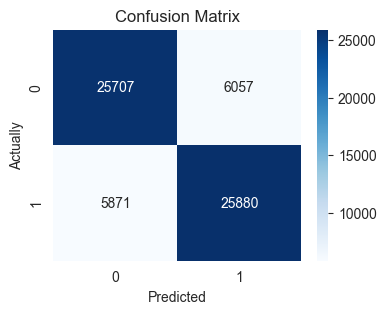


Recall: 0.8150924380334478

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     31764
           1       0.81      0.82      0.81     31751

    accuracy                           0.81     63515
   macro avg       0.81      0.81      0.81     63515
weighted avg       0.81      0.81      0.81     63515

0.8150924380334478


<Figure size 640x480 with 0 Axes>

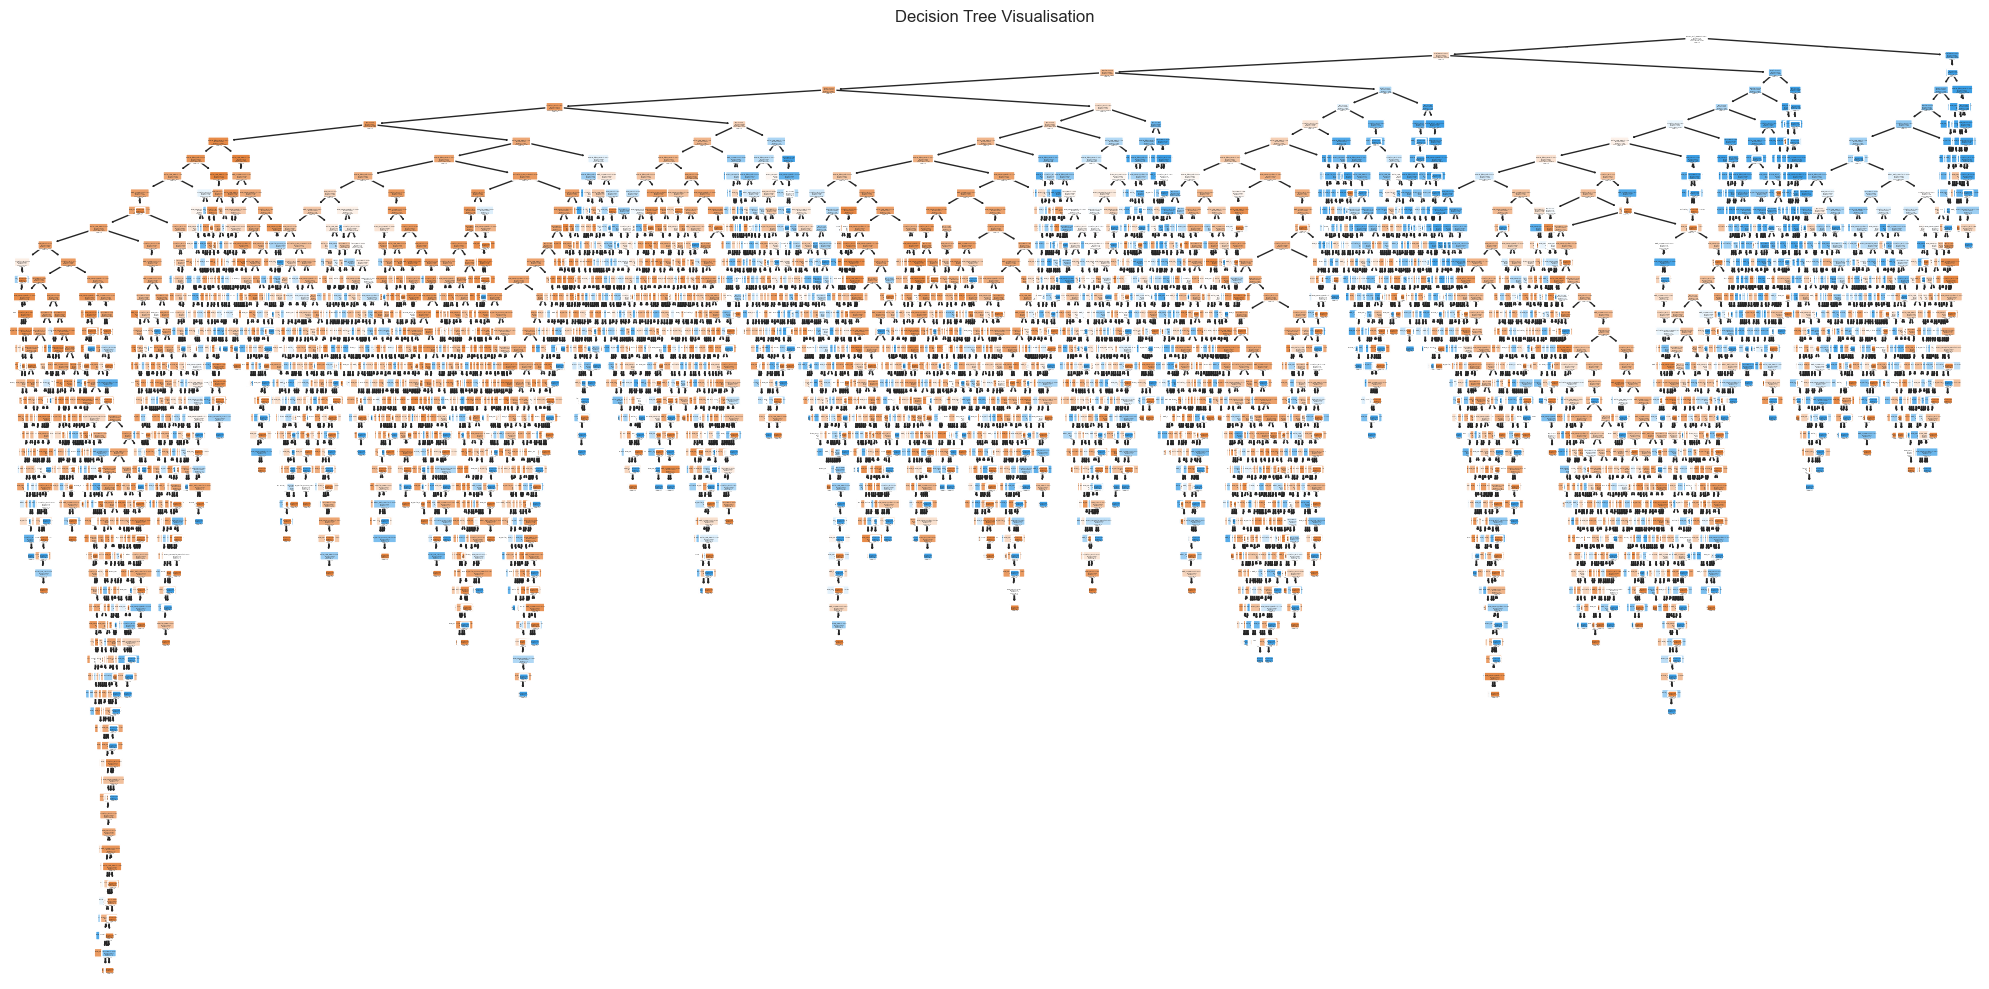

Interval of confidence: (0.812061523317642, 0.8181073946904189)


In [38]:
from statsmodels.stats.proportion import proportion_confint
cdt= DecisionTreeClassifier(
    criterion = "entropy",
    min_samples_split = clf.best_params_["min_samples_split"],
    min_impurity_decrease = clf.best_params_["min_impurity_decrease"],
    random_state=1
)
clf = cdt.fit(X_train, y_train)
pred = clf.predict(X_test)

print(f"prediction: {[pred]}")
print(clf.score(X_test, y_test))
conf_matrix=confusion_matrix(y_test,pred)
print(conf_matrix)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actually')
plt.title('Confusion Matrix')
plt.show()

print(f"\nRecall: {recall_score(y_test, pred)}\n")
print(classification_report(y_test, pred))

epsilon = recall_score(y_test, pred)
print(epsilon)

fig = plt.gcf()
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
plt.title('Decision Tree Visualisation')
#fig.savefig("tree.png")
plt.tight_layout()
plt.show()
estimated_tp_count = int(round(epsilon * X_test.shape[0]))
print("Interval of confidence:", proportion_confint(count=estimated_tp_count, nobs=X_test.shape[0], alpha=0.05, method='binom_test'))

## Learning Curve

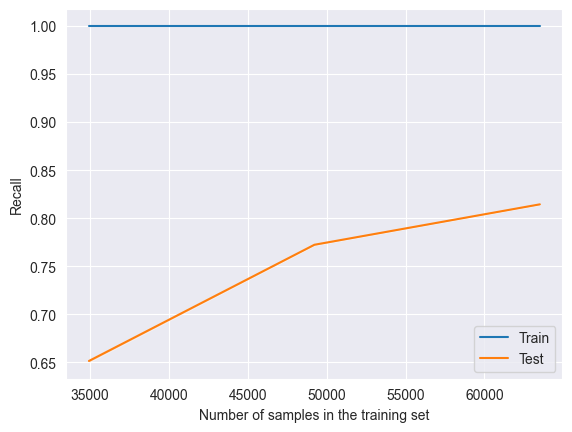

In [41]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv = 2, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='recall'
)

display=LearningCurveDisplay(train_sizes=train_sizes,train_scores=train_scores, test_scores=test_scores, score_name="Recall")
display.plot()
plt.show()


# Decorator for timing model execution


In [42]:
def compute_executions_time(function):
    def wrapper():
        start_time = time.time()  # init measuring time
        function()  # execute function
        print(f"\n{time.time() - start_time} seconds")  # print execution time
    return wrapper

## Random Forest


Recall: 0.781 ± 0.000 [nº estimators (trees): 1]
Recall: 0.665 ± 0.005 [nº estimators (trees): 2]
Recall: 0.812 ± 0.002 [nº estimators (trees): 5]
Recall: 0.792 ± 0.000 [nº estimators (trees): 10]
Recall: 0.803 ± 0.001 [nº estimators (trees): 20]
Recall: 0.809 ± 0.001 [nº estimators (trees): 50]
Recall: 0.812 ± 0.002 [nº estimators (trees): 100]
Recall: 0.813 ± 0.002 [nº estimators (trees): 200]


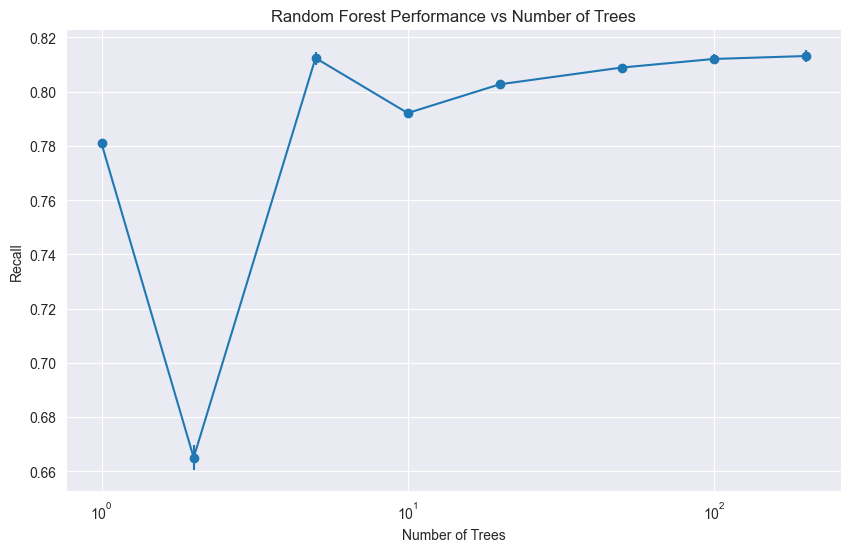


129.1187608242035 seconds


In [43]:
@compute_executions_time
def execute_random_forest_with_different_estimators_and_cv(cv=2):
    results = []
    options = [1, 2, 5, 10, 20, 50, 100, 200]
    for n_trees in options:
        random_forest_clf = RandomForestClassifier(
            n_estimators=n_trees,
            random_state=1
        )
        scores = cross_val_score(
            estimator=random_forest_clf,
            X=X,
            y=y,
            cv=cv,
            scoring="recall"
        )
        results.append((n_trees, scores.mean(), scores.std()))
        print(f"Recall: {scores.mean():.3f} ± {scores.std():.3f} [nº estimators (trees): {n_trees}]")

    plt.figure(figsize=(10, 6))
    means = [r[1] for r in results]
    stds = [r[2] for r in results]
    plt.errorbar(options, means, yerr=stds, fmt='-o')
    plt.xlabel('Number of Trees')
    plt.ylabel('Recall')
    plt.title('Random Forest Performance vs Number of Trees')
    plt.xscale('log')
    plt.grid(True)
    plt.show()
execute_random_forest_with_different_estimators_and_cv()

## Bagging

Recall: 0.810 ± 0.000 [nº estimators: 1]
Recall: 0.737 ± 0.004 [nº estimators: 2]
Recall: 0.814 ± 0.001 [nº estimators: 5]
Recall: 0.794 ± 0.002 [nº estimators: 10]
Recall: 0.801 ± 0.003 [nº estimators: 20]
Recall: 0.805 ± 0.001 [nº estimators: 50]
Recall: 0.806 ± 0.001 [nº estimators: 100]
Recall: 0.807 ± 0.001 [nº estimators: 200]
Recall: 0.603 ± 0.000 [nº estimators: 1]
Recall: 0.312 ± 0.001 [nº estimators: 2]
Recall: 0.629 ± 0.001 [nº estimators: 5]
Recall: 0.684 ± 0.001 [nº estimators: 10]
Recall: 0.737 ± 0.000 [nº estimators: 20]
Recall: 0.776 ± 0.001 [nº estimators: 50]
Recall: 0.787 ± 0.002 [nº estimators: 100]
Recall: 0.789 ± 0.003 [nº estimators: 200]


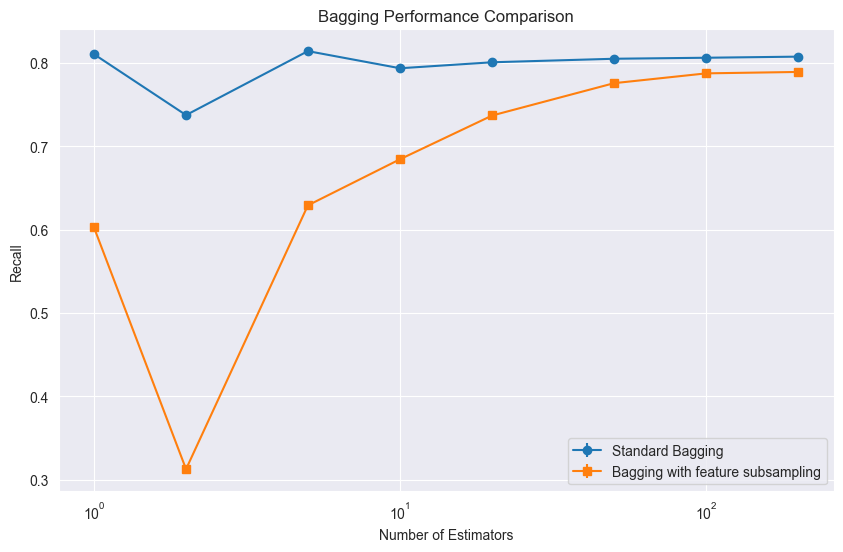


791.1399610042572 seconds


In [45]:
@compute_executions_time
def execute_bagging_with_different_configurations(cv=2):
    options = [1, 2, 5, 10, 20, 50, 100, 200]
    lb1 = []
    for nest in options:
        scores = cross_val_score(
            BaggingClassifier(
                estimator = DecisionTreeClassifier(),
                n_estimators = nest,
                random_state=1
            ),
            X,
            y,
            cv = cv,
            scoring="recall"
        )
        lb1.append((nest, scores.mean(), scores.std()))
        print(f"Recall: {scores.mean():.3f} ± {scores.std():.3f} [nº estimators: {nest}]")
    lb2 = []
    for nest in options:
        scores = cross_val_score(
            BaggingClassifier(
                estimator=DecisionTreeClassifier(),
                n_estimators=nest,
                max_features=0.35,
                random_state=1
            ),
            X,
            y,
            cv=cv,
            scoring="recall"
        )
        lb2.append((nest, scores.mean(), scores.std()))
        print(f"Recall: {scores.mean():.3f} ± {scores.std():.3f} [nº estimators: {nest}]")

    plt.figure(figsize=(10, 6))

    means1 = [r[1] for r in lb1]
    stds1 = [r[2] for r in lb1]
    plt.errorbar(options, means1, yerr=stds1, fmt='-o', label='Standard Bagging')

    means2 = [r[1] for r in lb2]
    stds2 = [r[2] for r in lb2]
    plt.errorbar(options, means2, yerr=stds2, fmt='-s', label='Bagging with feature subsampling')

    plt.xlabel('Number of Estimators')
    plt.ylabel('Recall')
    plt.title('Bagging Performance Comparison')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()

execute_bagging_with_different_configurations()

## Extra Trees Classifiers

Recall: 0.745 ± 0.001 [nº estimators (trees): 1]
Recall: 0.614 ± 0.007 [nº estimators (trees): 2]
Recall: 0.785 ± 0.001 [nº estimators (trees): 5]
Recall: 0.759 ± 0.001 [nº estimators (trees): 10]
Recall: 0.776 ± 0.001 [nº estimators (trees): 20]
Recall: 0.785 ± 0.000 [nº estimators (trees): 50]
Recall: 0.790 ± 0.004 [nº estimators (trees): 100]
Recall: 0.791 ± 0.003 [nº estimators (trees): 200]


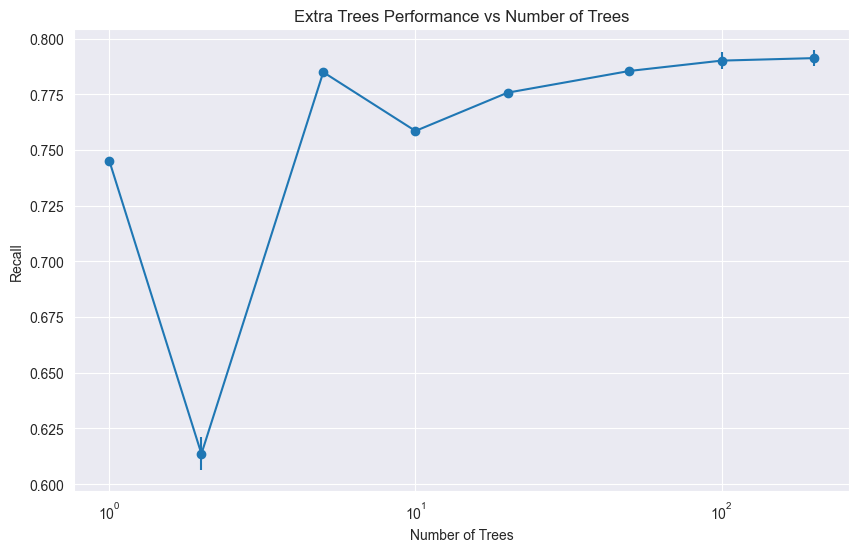


122.17393159866333 seconds


In [46]:
¡@compute_executions_time
def execute_extra_trees_classifier_with_different_estimators_and_cv(cv=2):
    results = []
    options = [1, 2, 5, 10, 20, 50, 100, 200]
    for n_trees in options:
        extra_trees_classifier = ExtraTreesClassifier(
            n_estimators = n_trees,
            random_state=1
        )
        scores = cross_val_score(
            estimator = extra_trees_classifier,
            X = X,
            y = y,
            cv = cv,
            scoring = "recall"
        )
        results.append((n_trees, scores.mean(), scores.std()))
        print(f"Recall: {scores.mean():.3f} ± {scores.std():.3f} [nº estimators (trees): {n_trees}]")
    plt.figure(figsize=(10, 6))
    means = [r[1] for r in results]
    stds = [r[2] for r in results]
    plt.errorbar(options, means, yerr=stds, fmt='-o')
    plt.xlabel('Number of Trees')
    plt.ylabel('Recall')
    plt.title('Extra Trees Performance vs Number of Trees')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

execute_extra_trees_classifier_with_different_estimators_and_cv()


## Ada Boost Classifier

Recall: 0.391 ± 0.059 [nº estimators: 1]
Recall: 0.391 ± 0.059 [nº estimators: 2]
Recall: 0.609 ± 0.174 [nº estimators: 5]
Recall: 0.700 ± 0.034 [nº estimators: 10]
Recall: 0.808 ± 0.004 [nº estimators: 20]
Recall: 0.805 ± 0.005 [nº estimators: 50]
Recall: 0.852 ± 0.002 [nº estimators: 100]
Recall: 0.853 ± 0.001 [nº estimators: 200]


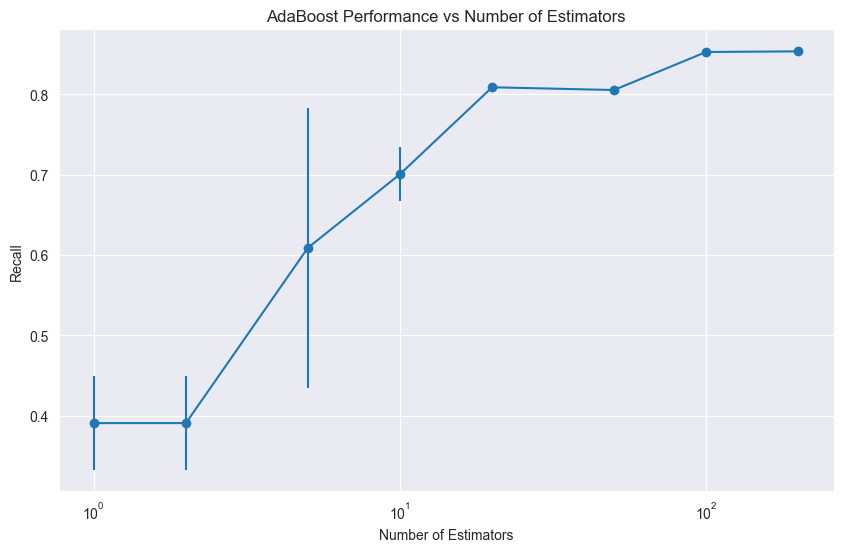


93.10527515411377 seconds


In [55]:
@compute_executions_time
def execute_ada_boost_classifier_for_different_classifiers(cv=2):
    results = []
    options = [1, 2, 5, 10, 20, 50, 100, 200]
    for n_estimators in options:
        ada_boos_classifier = AdaBoostClassifier(
            n_estimators=n_estimators,
            random_state=1
        )
        scores = cross_val_score(
            ada_boos_classifier,
            X,
            y,
            cv = cv,
            scoring = "recall"
        )
        results.append((n_estimators, scores.mean(), scores.std()))
        print(f"Recall: {scores.mean():.3f} ± {scores.std():.3f} [nº estimators: {n_estimators}]")

    plt.figure(figsize=(10, 6))
    means = [r[1] for r in results]
    stds = [r[2] for r in results]
    plt.errorbar(options, means, yerr=stds, fmt='-o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Recall')
    plt.title('AdaBoost Performance vs Number of Estimators')
    plt.xscale('log')
    plt.grid(True)
    plt.show()
execute_ada_boost_classifier_for_different_classifiers()


 ## Voting Scheme

### (para hacer la comparación de todos los metodos)
